In [107]:
#####
# Necessary Libraries
#####
import os
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from scipy.spatial.distance import cdist
import scipy.cluster.hierarchy as sch
from sklearn.metrics import precision_score, recall_score, roc_curve, auc
from dmba import classificationSummary

In [109]:
#####
# Cluster Analysis setup
#####

# Load dataset and display basic info
df = pd.read_csv('WA_Fn-UseC_-HR-Employee-Attrition.csv')
display(df.head())
display(df.info())

# Data Cleaning and Normalization, converting categorical variables to numerical
label_encoders = {}
categorical_cols = ['Attrition', 'JobRole', 'EducationField', 'BusinessTravel', 'Gender', 'Department']
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Handle missing values if any and standardize data
df = df.dropna()
scaler = StandardScaler()
numerical_cols = ['Age', 'DistanceFromHome', 'MonthlyIncome', 'TotalWorkingYears', 'YearsAtCompany']
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

None

In [111]:
#####
# Finding centroids and distances
#####

# Select variables for clustering
cluster_features = ['DistanceFromHome', 'JobRole', 'Attrition', 'MonthlyIncome']
df_cluster = df[cluster_features]
df_cluster_scaled = scaler.fit_transform(df_cluster)

# Finding distances between centroids
distances = cdist(kmeans.cluster_centers_, kmeans.cluster_centers_, metric='euclidean')
distance_df = pd.DataFrame(distances, columns=[f'Cluster {i}' for i in range(len(distances))], index=[f'Cluster {i}' for i in range(len(distances))])
display(distance_df)
print("Distance Between Clusters:\n", distance_df)

,Cluster 0,Cluster 1,Cluster 2
Cluster 0,0.000000,1.915513,3.099662
Cluster 1,1.915513,0.000000,2.816188
Cluster 2,3.099662,2.816188,0.000000


Distance Between Clusters:
            Cluster 0  Cluster 1  Cluster 2
Cluster 0   0.000000   1.915513   3.099662
Cluster 1   1.915513   0.000000   2.816188
Cluster 2   3.099662   2.816188   0.000000


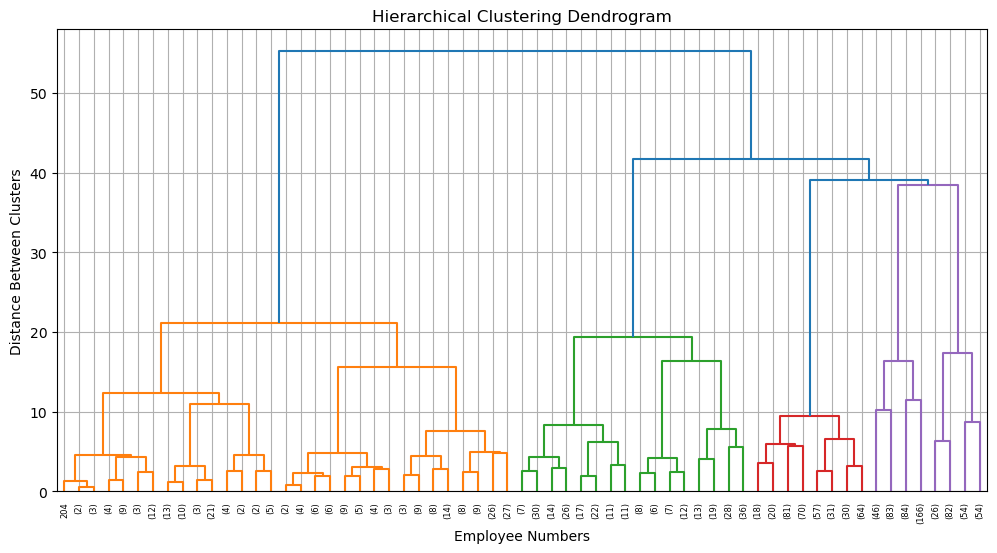

In [113]:
#####
# Perform Hierarchical Clustering
#####
plt.figure(figsize=(12, 6))
linkage_matrix = sch.linkage(df_cluster_scaled, method='ward')
sch.dendrogram(linkage_matrix, truncate_mode='level', p=5)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Employee Numbers')
plt.ylabel('Distance Between Clusters')
plt.grid(True)
plt.show()

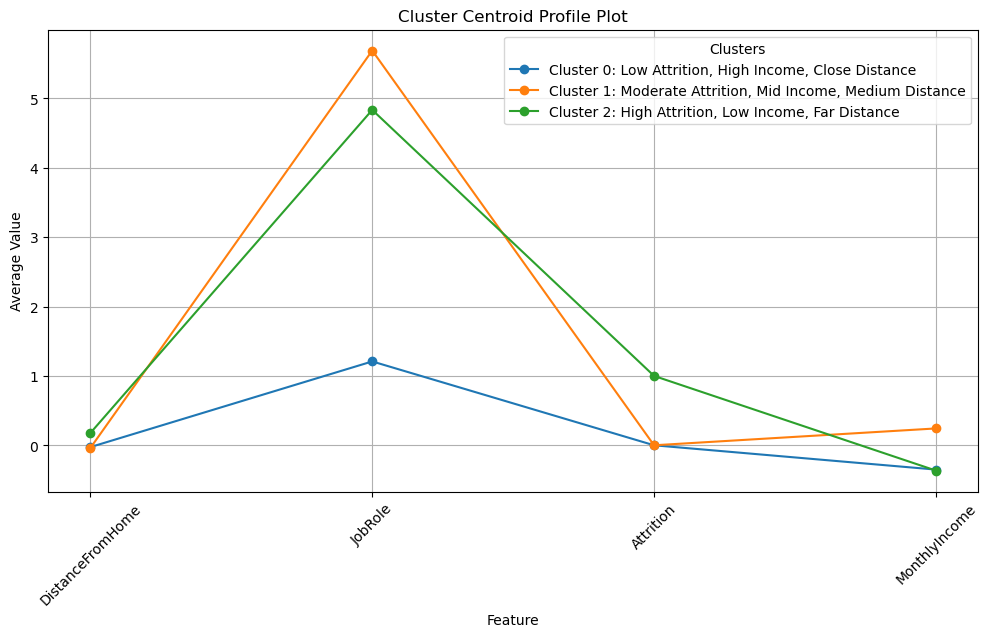

In [114]:
#####
# Profile plot of cluster centroids
#####
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=cluster_features)
centroids = scaler.inverse_transform(centroids)
centroids = pd.DataFrame(centroids, columns=cluster_features)

plt.figure(figsize=(12, 6))
for i in range(len(centroids)):
    plt.plot(cluster_features, centroids.iloc[i], marker='o', label=f'Cluster {i}')

plt.title('Cluster Centroid Profile Plot')
plt.xlabel('Feature')
plt.ylabel('Average Value')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title='Clusters', labels=[
    'Cluster 0: Low Attrition, High Income, Close Distance',
    'Cluster 1: Moderate Attrition, Mid Income, Medium Distance',
    'Cluster 2: High Attrition, Low Income, Far Distance'])
plt.show()

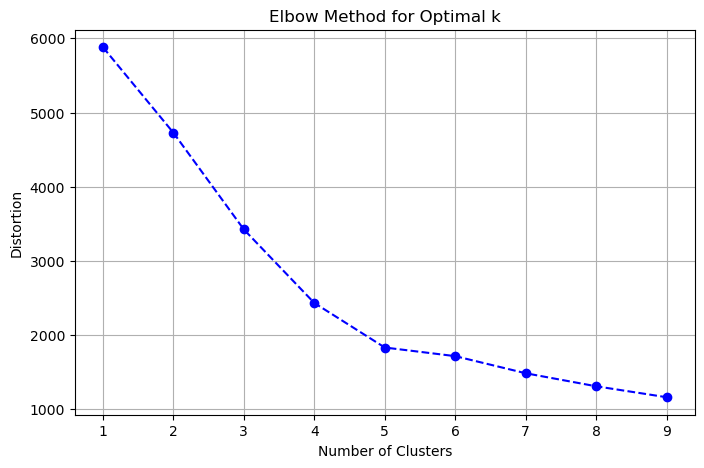

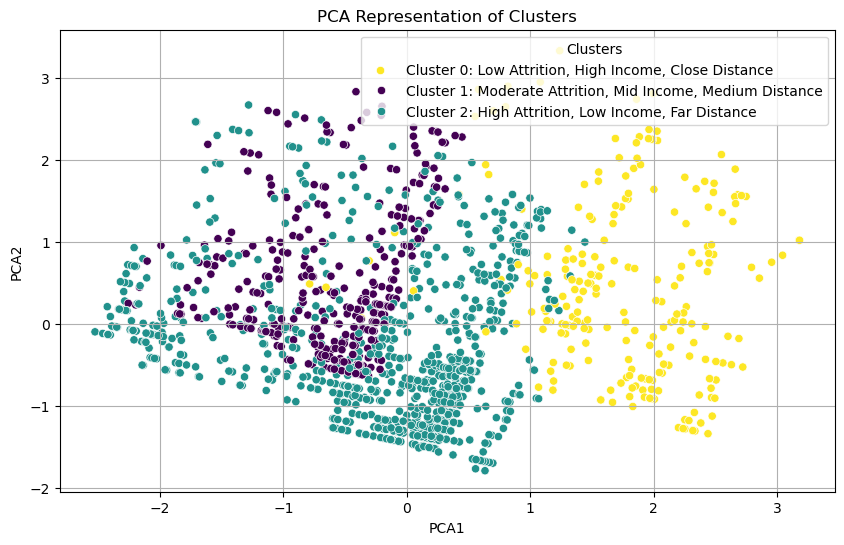

In [115]:
#####
# Elbow method and PCA's
#####

# Elbow Method
distortions = []
k_values = range(1, 10)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_cluster_scaled)
    distortions.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_values, distortions, marker='o', linestyle='--', color='b')
plt.xlabel('Number of Clusters')
plt.ylabel('Distortion')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

# K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(df_cluster_scaled)

# PCA Charting
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_cluster_scaled)
df['PCA1'] = df_pca[:, 0]
df['PCA2'] = df_pca[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['PCA1'], y=df['PCA2'], hue=df['Cluster'], palette='viridis')
plt.title('PCA Representation of Clusters')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Clusters', labels=[
    'Cluster 0: Low Attrition, High Income, Close Distance',
    'Cluster 1: Moderate Attrition, Mid Income, Medium Distance',
    'Cluster 2: High Attrition, Low Income, Far Distance'])
plt.grid(True)
plt.show()

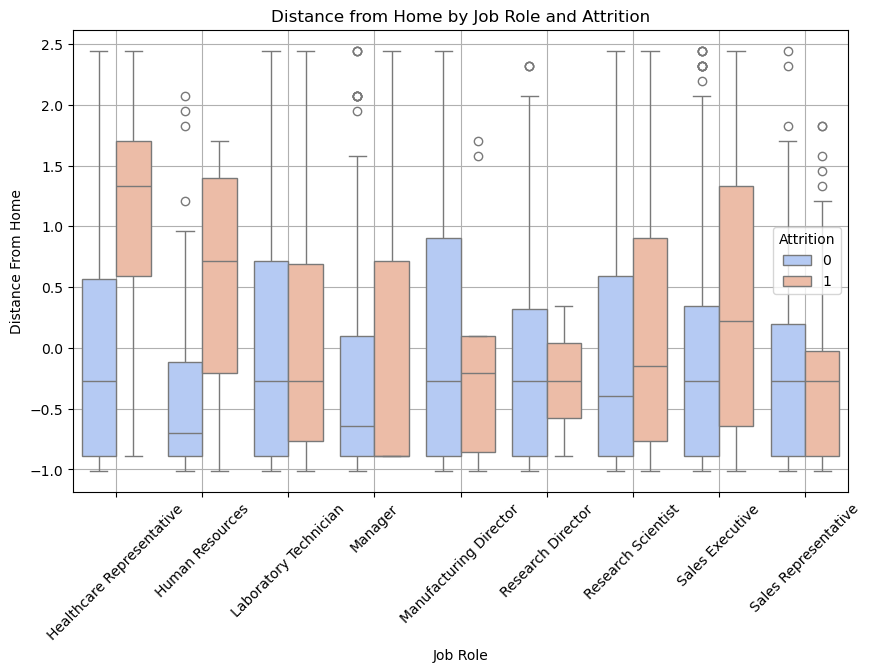

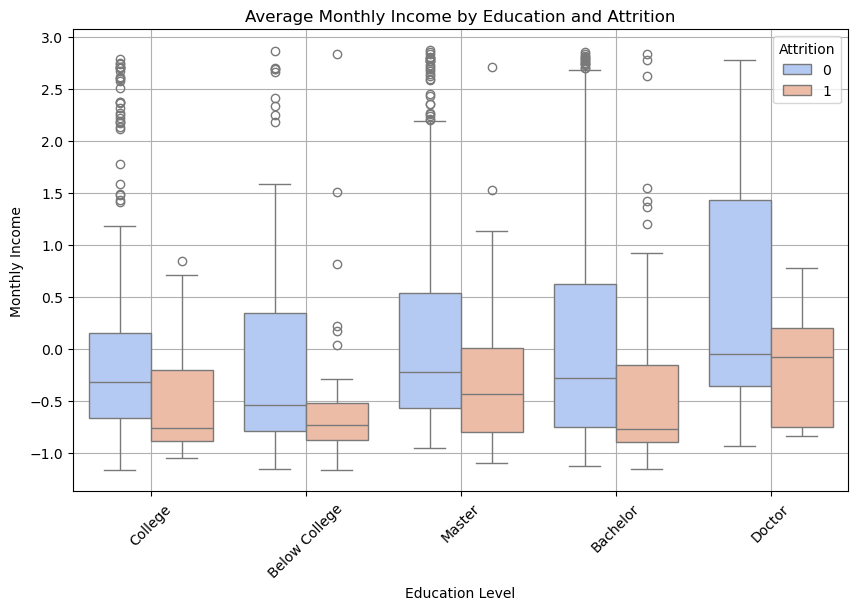

In [116]:
#####
# Box Plots 
#####

# Showing corralation to Distrance, Role, and Attrition
plt.figure(figsize=(10, 6))
sns.boxplot(x='JobRole', y='DistanceFromHome', hue='Attrition', data=df, palette='coolwarm')
plt.title('Distance from Home by Job Role and Attrition')
plt.xlabel('Job Role')
plt.ylabel('Distance From Home')
plt.xticks(ticks=range(len(label_encoders['JobRole'].classes_)), labels=label_encoders['JobRole'].classes_, rotation=45)
plt.grid(True)
plt.show()

# Showing corralation to Income, Education, and Attrition
plt.figure(figsize=(10, 6))
education_mapping = {1: 'Below College', 2: 'College', 3: 'Bachelor', 4: 'Master', 5: 'Doctor'}
df['EducationLabel'] = df['Education'].map(education_mapping)
sns.boxplot(x='EducationLabel', y='MonthlyIncome', hue='Attrition', data=df, palette='coolwarm')
plt.title('Average Monthly Income by Education and Attrition')
plt.xlabel('Education Level')
plt.ylabel('Monthly Income')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [131]:
#####
# Logistic Regression setup
#####

# Reload the data set to start fresh without modifications from previous calculations
df = pd.read_csv("WA_Fn-UseC_-HR-Employee-Attrition.csv")

# Categorical variables
label_encoders = {}
for col in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Define target variable
X = df.drop(columns=['Attrition', 'EmployeeNumber', 'Over18', 'StandardHours', 'EmployeeCount'])
y = df['Attrition']

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [141]:
#####
# Splitting data and creating our sets
#####

# Split data into training and validation, 60-40
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.4, random_state=42, stratify=y)

# Train model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predictions
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)

# Generate possibilites for ROC curve
y_train_prob = model.predict_proba(X_train)[:, 1]
y_val_prob = model.predict_proba(X_val)[:, 1]

# Print confusion matrices
print("Training Set:")
classificationSummary(y_train, y_train_pred)
print("\nValidation Set:")
classificationSummary(y_val, y_val_pred)

# Compute precision, recall, and specificity
def calculate_metrics(y_true, y_pred):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    specificity = recall_score(y_true, y_pred, pos_label=0)
    return precision, recall, specificity

# Calculate_metrics for training and validation set, then print
precision_train, recall_train, specificity_train = calculate_metrics(y_train, y_train_pred)
precision_val, recall_val, specificity_val = calculate_metrics(y_val, y_val_pred)
print("\nPerformance Metrics:")
print("Training Set: \n\tPrecision: {:.2f}, \n\tRecall: {:.2f}, \n\tSpecificity: {:.2f}".format(precision_train, recall_train, specificity_train))
print("Validation Set: \n\tPrecision: {:.2f}, \n\tRecall: {:.2f}, \n\tSpecificity: {:.2f}".format(precision_val, recall_val, specificity_val))


Training Set:
Confusion Matrix (Accuracy 0.8798)

       Prediction
Actual   0   1
     0 720  20
     1  86  56

Validation Set:
Confusion Matrix (Accuracy 0.8656)

       Prediction
Actual   0   1
     0 477  16
     1  63  32

Performance Metrics:
Training Set: 
	Precision: 0.74, 
	Recall: 0.39, 
	Specificity: 0.97
Validation Set: 
	Precision: 0.67, 
	Recall: 0.34, 
	Specificity: 0.97


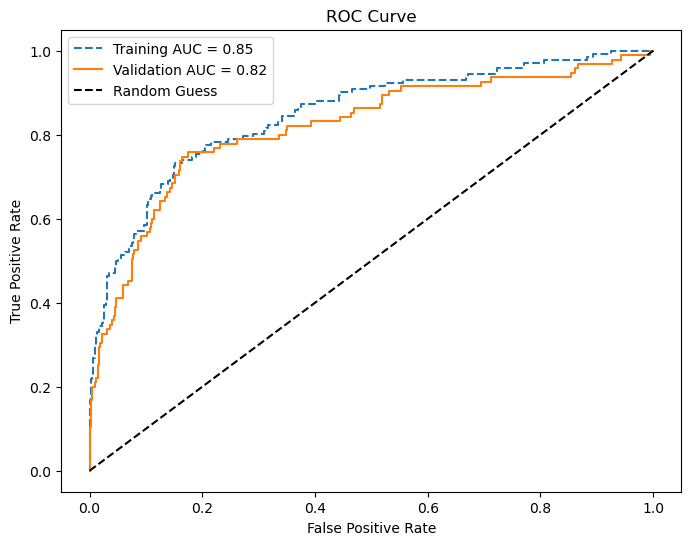

In [143]:
#####
# Calculation ROC 
#####

# Compute ROC curve and AUC
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_prob)
fpr_val, tpr_val, _ = roc_curve(y_val, y_val_prob)
auc_train = auc(fpr_train, tpr_train)
auc_val = auc(fpr_val, tpr_val)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label=f'Training AUC = {auc_train:.2f}', linestyle='--')
plt.plot(fpr_val, tpr_val, label=f'Validation AUC = {auc_val:.2f}', linestyle='-')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

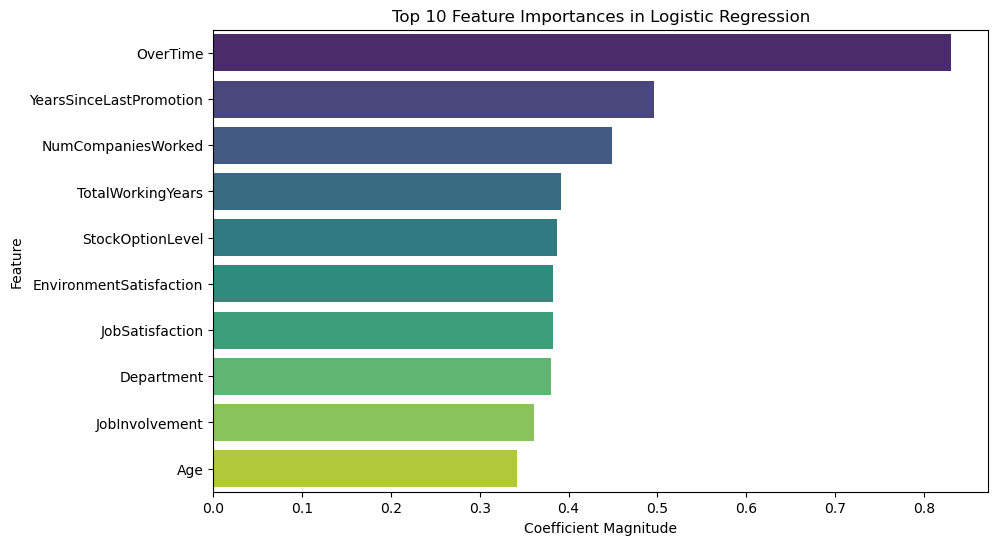

In [147]:
#####
# Bar Plot showing which variables links most to Attrition
#####

# Calculate feature importance
feature_importance = np.abs(model.coef_[0])
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(10)

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', hue='Feature', data=importance_df, palette='viridis', legend=False)
plt.title('Top 10 Feature Importances in Logistic Regression')
plt.xlabel('Coefficient Magnitude')
plt.ylabel('Feature')
plt.show()
